In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns 


from sklearn.preprocessing import StandardScaler , PolynomialFeatures
from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.linear_model import LinearRegression , Ridge , Lasso 
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import *
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

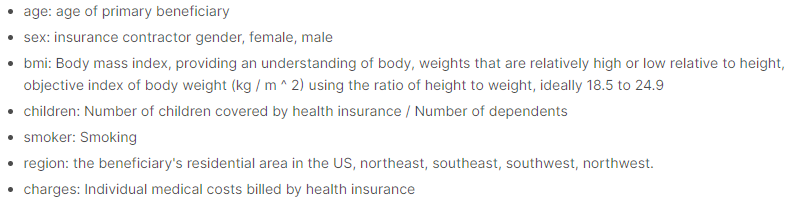

In [ ]:
# Import Dataset

df = pd.read_csv('/kaggle/input/insurance/insurance.csv')
df.head()

In [ ]:
# Dataset Info

df.info()

In [ ]:
# Descriptive Statistics Detail

df.describe().T

In [ ]:
# Have Missing Values ?

df.isna().sum()

In [ ]:
# Have Duplicate Rows ? 

df.duplicated().sum()

In [ ]:
df[df.duplicated(keep=False)]

In [ ]:
# Just Drop It !

df = df.drop_duplicates()
df.duplicated().sum()

In [ ]:
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (12,8)

In [ ]:
# Show Distribution of Charges

sns.histplot(data=df , x='charges' , bins=20 , kde=True)
plt.title('Distribution of Charges')

In [ ]:
# Show Counts of Each Categories 

fig , axs = plt.subplots(nrows=1 , ncols=4 , figsize=(15,5) , sharey=True)
axs = axs.ravel()

for index , col in enumerate(['sex' , 'children' ,'smoker', 'region']) : 
    sns.countplot(data=df , x=col , ax=axs[index])
plt.tight_layout()

In [ ]:
def charges_dist_by_cate(col):
    fig , axs = plt.subplots(nrows=1 , ncols=2 , figsize=(15,5) , sharex=True )
    axs = axs.ravel()

    sns.histplot(data=df , x='charges' , kde=True , hue=col, ax=axs[0])
    sns.boxenplot(data=df , x='charges', y=col ,orient='h', ax=axs[1])

In [ ]:
# Show Distribution of Charges by Sex

charges_dist_by_cate('sex')

In [ ]:
# Show Distribution of Charges by Children

charges_dist_by_cate('children')

In [ ]:
# Show Distribution of Charges by Smoker

charges_dist_by_cate('smoker')

In [ ]:
# Show Distribution of Charges by Region

charges_dist_by_cate('region')

In [ ]:
# Show Charges vs. BMI by Smoker

sns.lmplot(data=df , x='bmi', y='charges'  , hue='smoker' , height=7 , markers=['o','x'])

In [ ]:
# Show Charges vs. Age by Smoker

sns.lmplot(data=df , x='age' , y='charges'  , hue='smoker' , height=7 , markers=['o','x'])

In [ ]:
# Data Engineering

df_dummies = df.copy()

for i in df_dummies.columns : 
    if df_dummies[i].dtype == 'object' : 
        dummies = pd.get_dummies(df_dummies[i] , prefix=f'{i}_')
        df_dummies = pd.concat([df_dummies , dummies] , axis=1)
        df_dummies = df_dummies.drop(i , axis=1)

In [ ]:
df_dummies.head()

In [ ]:
# Show Correlation of Each Feature

sns.heatmap(df_dummies.corr() ,mask=np.triu(df_dummies.corr()) ,annot=True , fmt='.2f' , cmap='RdBu', linewidths=1)

In [ ]:
# Data Preparation

features = df_dummies.drop('charges' , axis=1)
target = df_dummies[['charges']]

In [ ]:
# Split Train and Test Dataset

x_train , x_test  , y_train , y_test = train_test_split( features , target , test_size=0.15 , shuffle=True)

In [ ]:
print('Train size :' , x_train.shape)
print('Test size :' , x_test.shape) 

In [ ]:
# Modeling Function

lis_result = []

def model_prediction(model) : 
    
    fig , axs = plt.subplots(nrows=1 , ncols=2 , figsize=(15,5) , sharex=True ,  sharey=True )
    axs = axs.ravel()
    
    scores = []
    
    for index , degree in enumerate([1,2]) : 
        
        pipeline = Pipeline([
            ('degree' , PolynomialFeatures(degree=degree)) , 
            ('scaled' , StandardScaler()) ,
            ('model' , model)
        ])

        pipeline.fit(x_train , y_train)
        prediction = pipeline.predict(x_test)
        
        r2 = r2_score(prediction , y_test).round(4)
        mae = mean_absolute_error(prediction , y_test).round(1)
        rmse = np.sqrt(mean_squared_error(prediction , y_test)).round(1)
        model_name = str(model).split('(')[0]
        
        scores.append([r2 , mae , rmse])
        lis_result.append([f'{model_name}, Degree={degree}' , r2 , mae , rmse])

        
        axs[index].scatter(prediction , y_test , color='green' , alpha=0.4)
        axs[index].plot(np.arange(max(y_test.values)) , np.arange(max(y_test.values)) , '-' , color='r' )
        axs[index].set_xlabel('Prediction')
        axs[index].set_ylabel('Real')
        axs[index].set_title(f'{model_name} with {degree} Degree')
        axs[index].legend([f'R2 : {r2} \nMAE : {mae} \nRMSE : {rmse}'] , loc='upper left')


In [ ]:
model_prediction(LinearRegression())

In [ ]:
model_prediction(Lasso())

In [ ]:
model_prediction(Ridge())

In [ ]:
model_prediction(RandomForestRegressor())

In [ ]:
model_prediction(XGBRegressor())

In [ ]:
lis_result[0]

In [ ]:
df_result = pd.DataFrame(lis_result , columns=['Model' , 'R2' , 'MAE' , 'RMSE']).sort_values(['MAE' , 'RMSE'] , ignore_index=True).set_index('Model')

> **The Best Model for Medical Cost Prediction is....**

In [ ]:
df_result.iloc[[0]]

In [ ]:
# All Results

df_result

### Upvote Upvote Upvote !! ⬆️ Don't Forget It
### Thank You. 🙏😁